In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import time
import os
from sklearn.decomposition import TruncatedSVD

from aml_utils import test_case_checker, perform_computation

## <span style="color:red">**Attention:**</span>

This assignment is computationally heavy, and inefficient implementations may not pass the autograding even if they technically produce the correct results. To avoid this, make sure you read and understand all the instructions before starting to implement the tasks. Failure to follow the instructions closely will most likely cause timeouts.

It is **your responsibility** to make sure your implementation is not only **correct**, but also as **efficient** as possible. If you follow all the instructions provided, you should be able to have all the cells evaluated in under 10 minutes.

# *Assignment Summary

CIFAR-10 is a dataset of 32x32 images in 10 categories, collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. It is often used to evaluate machine learning algorithms. You can download this dataset from https://www.cs.toronto.edu/~kriz/cifar.html.

  * For each category, compute the mean image and the first 20 principal components. Plot the error resulting from representing the images of each category using the first 20 principal components against the category.
  * Compute the distances between mean images for each pair of classes. Use principal coordinate analysis to make a 2D map of the means of each categories. For this exercise, compute distances by thinking of the images as vectors.
  * Here is another measure of the similarity of two classes. For class A and class B, define E(A | B) to be the average error obtained by representing all the images of class A using the mean of class A and the first 20 principal components of class B. Now define the similarity between classes to be (1/2)(E(A | B) + E(B | A)). If A and B are very similar, then this error should be small, because A's principal components should be good at representing B. But if they are very different, then A's principal components should represent B poorly. In turn, the similarity measure should be big. Use principal coordinate analysis to make a 2D map of the classes. Compare this map to the map in the previous exercise? are they different? why?

# 0. Data

## 0.1 Description

CIFAR-10 is a dataset of 32x32 images in 10 categories, collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. It is often used to evaluate machine learning algorithms. You can download this dataset from https://www.cs.toronto.edu/~kriz/cifar.html.

## 0.2 Information Summary

* **Input/Output**: This data has a set of 32 pixel rows, 32 pixel columns, and 3 color channels. Therefore, each single image, is vectorized, will consist of $32\times32\times3$ elements (i.e., each image has 3072 dimensions). There are a total of 60000 samples labelled from 10 class. The data set is balanced with each class having exactly 6000 samples.

* **Missing Data**: There is no missing data.

* **Final Goal**: We want to understand the data using multi-dimensional scaling methods.

## 0.3 Loading The Data

If you are curious how the original data was obtained, we used the torchvision API to download and pre-process it. The ready-to-use data is stored in numpy format for easier access.

In [2]:
if os.path.exists('cifar10.npz'):    
    np_file = np.load('cifar10.npz')
    train_images_raw = np_file['train_images_raw']
    train_labels = np_file['train_labels']
    eval_images_raw = np_file['eval_images_raw']
    eval_labels = np_file['eval_labels']

else:
    import torchvision
    download_ = not os.path.exists('./cifar10/')
    data_train = torchvision.datasets.CIFAR10('cifar10', train=True, transform=None, target_transform=None, download=download_)
    data_eval = torchvision.datasets.CIFAR10('cifar10', train=False, transform=None, target_transform=None, download=download_)
    train_images_raw = data_train.data
    train_labels = np.array(data_train.targets)
    eval_images_raw = data_eval.data
    eval_labels = np.array(data_eval.targets)
    np.savez('cifar10.npz', train_images_raw=train_images_raw, train_labels=train_labels, 
             eval_images_raw=eval_images_raw, eval_labels=eval_labels)

c:\Users\Djcho\anaconda3\envs\MachineLearning\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] No se encontró el proceso especificado'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
class_to_idx = {'airplane': 0,
                'automobile': 1,
                'bird': 2,
                'cat': 3,
                'deer': 4,
                'dog': 5,
                'frog': 6,
                'horse': 7,
                'ship': 8,
                'truck': 9}

In [4]:
images_raw = np.concatenate([train_images_raw, eval_images_raw], axis=0)
labels = np.concatenate([train_labels, eval_labels], axis=0)
images_raw.shape, labels.shape

((60000, 32, 32, 3), (60000,))

# 1. Principal Component Analysis

0. Let's say we have Data Matrix $X$ with $N$ rows (i.e., data points) and $d$ columns (i.e., features).
$$X = [\cdots]_{N \times d}$$
1. Let's perform SVD on the $X$.
$$X=U_x S_x V_x^T$$
Let's assume $N>d$ (We have 6000 data points per class, which is more than the 3072 dimenstions).

By the way SVD works, we should have
$$U_x = [\cdots]_{N \times d}$$
$$S_x = [\cdots]_{d \times d}$$
$$V_x = [\cdots]_{d \times d}$$
and
$$U_x^T U_x = I_{d\times d}$$
$$V_x^T V_x = I_{d\times d}$$

2. The textbook says we need the following decomposition for the covariance matrix $\Sigma$:
$$\Sigma \mathcal{U} = \mathcal{U} \Lambda$$
3. We assume that X has mean zero (i.e., we already subtracted the feature averages). If $X$ has $N$ rows (i.e., data items), we have
$$\Sigma = \frac{1}{N} X^TX$$
4. Let's find $\Sigma$ in terms of $U_x$, $S_x$, and $V_x$
$$\Sigma = \frac{1}{N} X^TX = \frac{1}{N} V_x S_x U_x^T U_x S_x V_x^T = V_x \frac{S_x^2}{N} V_x^T$$
$$\Rightarrow \Sigma V_x = V_x \frac{S_x^2}{N}$$
5. By comparison, we have
$$\mathcal{U} = V_x$$
$$\Lambda = \frac{S_x^2}{N}$$

### Considering the above:
1. **There is no need to compute the covariance matrix $\Sigma$** and then find its diagonalization; You can easily perform SVD on the data matrix $X$, and get what you need!
2. In fact, you do not even need the matrices $V_x$ and $U_x$ for computing the mean squared error; You can infer the mean squared error using only the $S_x$ matrix. 
    * Numpy's SVD function `np.linalg.svd` has an argument `compute_uv` that turns off returning the $U$ and $V$ matrices for better efficiency. Therefore, you may be able to save some runtime in large data sets if you only care about the mean squared error!

# <span style="color:blue">Task 1</span>

Write a function `pca_mse` that takes two arguments as input

1. `data_raw`: a numpy array with the shape $(N, \cdots)$, where $N$ is the number of samples, and there may be many excess dimensions denoted by $\cdots$. You will have to reshape this input `data_raw` matrix to obtain a shape of $(N, d)$, where $d$ is the vectorized data's dimension. For example, `data_raw` could have an input shape of `(6000, 50, 50, 3)`. In this case you will have to reshape the input data to have a shape of `(6000, 7500)`.
2. `num_components`: This is the number of PCA components that we want to retain. This variable is denoted by $r$ in the PCA definition in the textbook.

and returns the variable `mse` which is the mean squared error of the PCA projection into the designated number of principal components.

**Important Note**: Make sure you use `np.linalg.svd` for the SVD operation. Do not use any other matrix factorization function for this question (such as `np.linalg.eig`).

**Important Note**: Make sure you read and understand the notes from the previous cells before you start implementing. Failing to properly set the arguments for `np.linalg.svd` or trying to find the mean squared error by calculating the reconstruction error may cause extreme delays and timeouts for your implementation.

**Hint**: If you don't know how to extract the mean squared error of the PCA projection, or don't have a fresh probability and statistics memory, take a look at the Principal Component Analysis chapter of the most recent version of the textbook; the subsection titled "The error in a low-dimensional representation" explains how to find the mean squared error of the PCA projection as a function of the eigenvalues that were dropped.

In [8]:
def pca_mse(data_raw, num_components=20):
    
    # Reshape the data to (N, d)
    N = data_raw.shape[0]
    d = np.prod(data_raw.shape[1:])
    data_reshaped = data_raw.reshape(N, d)

    # Perform SVD on the reshaped data
    S = np.linalg.svd(data_reshaped, compute_uv=False)

    # Calculate the Mean Squared Error (MSE)
    # Only consider the eigenvalues/singular values for the discarded components
    # Ensure the correct singular values are considered for the discarded components
    discarded_variance = S[num_components:] ** 2
    mse = np.mean(discarded_variance)
        
    assert np.isscalar(mse)
    return np.float64(mse)

In [9]:
some_data = (np.arange(35).reshape(5,7) ** 13) % 20
some_mse = pca_mse(some_data, num_components=2)
print(some_mse)
assert some_mse.round(3) == 37.903

# Checking against the pre-computed test database
test_results = test_case_checker(pca_mse, task_id=1)
assert test_results['passed'], test_results['message']

104.84005583333023


AssertionError: 

In [10]:
if perform_computation:
    class_names = []
    class_mses = []
    for cls_name, cls_label in class_to_idx.items():
        data_raw = images_raw[labels == cls_label,:,:,:]
        start_time = time.time()
        print(f'Processing Class {cls_name}', end='')
        cls_mse = pca_mse(data_raw, num_components=20)
        print(f' (The SVD operation took %.3f seconds)' % (time.time()-start_time))
        class_names.append(cls_name)
        class_mses.append(cls_mse)

Processing Class airplane (The SVD operation took 5.081 seconds)
Processing Class automobile (The SVD operation took 5.067 seconds)
Processing Class bird (The SVD operation took 4.885 seconds)
Processing Class cat (The SVD operation took 4.851 seconds)
Processing Class deer (The SVD operation took 4.956 seconds)
Processing Class dog (The SVD operation took 5.234 seconds)
Processing Class frog (The SVD operation took 5.071 seconds)
Processing Class horse (The SVD operation took 4.985 seconds)
Processing Class ship (The SVD operation took 4.968 seconds)
Processing Class truck (The SVD operation took 5.085 seconds)


TypeError: barplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 1 keyword-only argument) were given

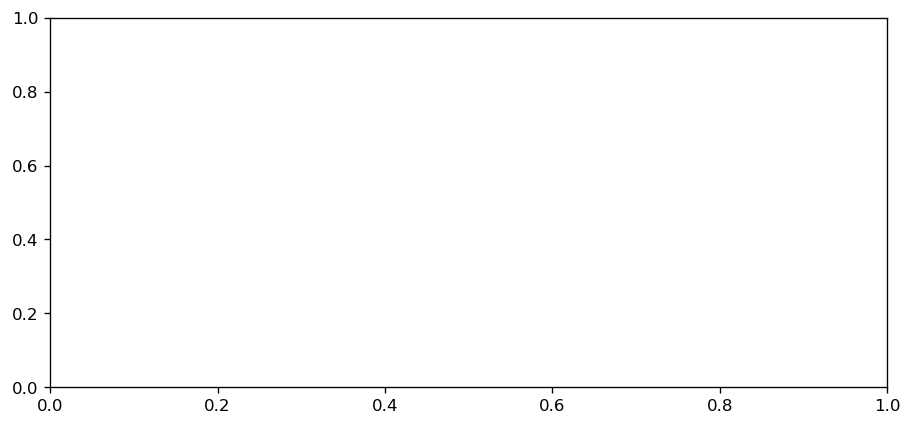

In [11]:
if perform_computation:
    fig, ax = plt.subplots(figsize=(9,4.), dpi=120)
    sns.barplot(class_names, class_mses, ax=ax)
    ax.set_title('The Mean Squared Error of Representing Each Class by the Principal Components')
    ax.set_xlabel('Class')
    _ = ax.set_ylabel('Mean Squared Error')

# 2. Principal Coordinate Analysis

In [12]:
class_mean_list = []
for cls_label in sorted(class_to_idx.values()):
    data_raw = images_raw[labels == cls_label,:,:,:]
    class_mean = np.mean(data_raw, axis=0).reshape(1,-1)
    class_mean_list.append(class_mean)
class_means = np.concatenate(class_mean_list, axis=0)

# <span style="color:blue">Task 2</span>

Write a function `mean_image_squared_distances` that takes the matrix `class_means` as an input and return the `SquaredDistances` matrix as output.

`class_means` is a numpy array like a traditional data matrix; it has a shape of $(N,d)$ where there are $N$ individual data-points where each is stored in a single $d$ dimensional row. $(N,d)$ could be anything, so do not make assumptions about it.

Your job is to produce the numpy array `SquaredDistances` whose $i^{th}$ row and $j^{th}$ column is the **squared** Euclidean distance between the $i^{th}$ row of `class_means` and $j^{th}$ row of `class_means`. Obviously
* The diagonal elements should be zero.
* The `SquaredDistances` should be symmetric.

In [13]:
def mean_image_squared_distances(class_means):
    
    # Number of rows in class_means
    num_rows = class_means.shape[0]

    # Initialize the squared distances matrix
    SquaredDistances = np.zeros((num_rows, num_rows))

    # Compute the squared Euclidean distance between each pair of rows
    for i in range(num_rows):
        for j in range(i, num_rows):
            # Calculate the squared Euclidean distance between row i and row j
            squared_distance = np.sum((class_means[i] - class_means[j]) ** 2)
            SquaredDistances[i, j] = squared_distance
            SquaredDistances[j, i] = squared_distance  # Maintain symmetry
    
    return SquaredDistances

In [14]:
some_data = ((np.arange(35).reshape(5,7) ** 13) % 20) / 7.
some_dist = mean_image_squared_distances(some_data)
assert np.array_equal(some_dist.round(3), np.array([[ 0.   ,  4.551, 18.204,  8.306, 14.041],
                                                    [ 4.551,  0.   , 12.714,  3.918, 12.551],
                                                    [18.204, 12.714,  0.   ,  8.633,  8.735],
                                                    [ 8.306,  3.918,  8.633,  0.   ,  7.49 ],
                                                    [14.041, 12.551,  8.735,  7.49 ,  0.   ]]))

# Checking against the pre-computed test database
test_results = test_case_checker(mean_image_squared_distances, task_id=2)
assert test_results['passed'], test_results['message']

AssertionError: 

# <span style="color:blue">Task 3</span>

Read and implement the Principal Coordinate Analysis procedure from your textbook by writing the function `PCoA` which takes the following arguments:
1. `SquaredDistances`: A numpy array which is square in shape, symmetric, and is the square of a distance matrix of some unknown set of points. The output of the `mean_image_squared_distances` function you wrote previously will be fed as this argument.

2. `r`: This is the dimension of the visualization space, and corresponds to the same $r$ variable in the textbook procedure.

Things to keep in mind:
1. There is an erratum in the textbook's description of the PCoA procedure. There is a missing negative sign when computing the matrix $\mathcal{W}$; the correct definition of $\mathcal{W}$ is $\mathcal{W}:=-\frac{1}{2}\mathcal{A}\mathcal{D}^{(2)}\mathcal{A}^T$.
2. It is **vital** to make sure that eigenvalues are sorted as the textbook mentioned, and the eigenvectors are also ordered accordingly. Some decomposition functions such as `numpy`'s `np.linalg.eig` do not guarantee to return the eigenvalues and eigenvectors in any sorted way, and `np.linalg.eigh` guarantees to return them in ascending order; you will have to make sure they are sorted as the textbook says.

**Note**: You should only use `np.linalg.eigh` for matrix factorization in this question since we're dealing with a symmetric matrix; do not use `np.linalg.eig`, `np.linalg.svd`, or any other matrix decomposition function in this question.

In [15]:
def PCoA(SquaredDistances, r=2):
    assert SquaredDistances.shape[0] == SquaredDistances.shape[1]
    num_points = SquaredDistances.shape[0]
    
    # Create the centering matrix H
    H = np.eye(num_points) - np.ones((num_points, num_points)) / num_points
    
    # Compute the double-centered matrix W
    W = -0.5 * H @ SquaredDistances @ H
    
    # Perform eigen decomposition on W
    eigenvalues, eigenvectors = np.linalg.eigh(W)
    
    # Sort the eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    
    # Select the top r eigenvectors and scale them by the square root of their corresponding eigenvalues
    VT = sorted_eigenvectors[:, :r] * np.sqrt(sorted_eigenvalues[:r])
    
    assert VT.shape[0] == num_points
    assert VT.shape[1] == r
    return VT

In [16]:
some_data = ((np.arange(35).reshape(5,7) ** 13) % 20) / 7.
some_dist = mean_image_squared_distances(some_data)
some_pcoa = PCoA(some_dist, r=2)
assert np.array_equal(some_pcoa.round(3), np.array([[-1.974,  0.421],
                                                    [-1.285, -0.646],
                                                    [ 1.98 , -1.137],
                                                    [-0.091, -0.266],
                                                    [ 1.369,  1.628]]))

# Checking against the pre-computed test database
test_results = test_case_checker(lambda *args, **kwargs: PCoA(*args, **kwargs).astype(np.complex128), task_id=3)
assert test_results['passed'], test_results['message']

AssertionError: 

In [17]:
if perform_computation:
    SquaredDistances = mean_image_squared_distances(class_means)
    VT = PCoA(SquaredDistances, r=2)

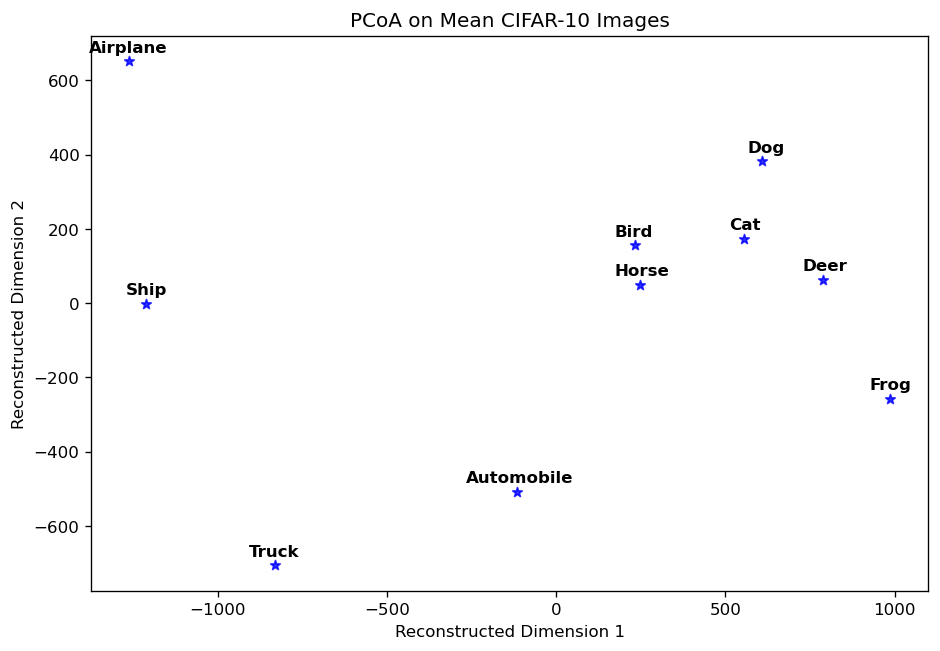

In [18]:
if perform_computation:
    class_names_list = sorted(list(class_to_idx.keys()))
    fig, ax = plt.subplots(figsize=(9,6.), dpi=120)
    x_components = VT[:,0]
    y_components = VT[:,1]
    sns.regplot(x=x_components, y=y_components, fit_reg=False, marker="*", color="Blue", ax=ax)
    for class_idx in range(VT.shape[0]):
        num_letters = len(class_names_list[class_idx])
        ax.text(x_components[class_idx]-num_letters*15, y_components[class_idx]+25, 
                class_names_list[class_idx].capitalize(), 
                horizontalalignment='left', size='medium', color='black', weight='semibold')
    ax.set_xlabel('Reconstructed Dimension 1')
    ax.set_ylabel('Reconstructed Dimension 2')
    _ = ax.set_title('PCoA on Mean CIFAR-10 Images')

# 3. Generalized PCoA with Non-Metric Similarities

# <span style="color:blue">Task 4</span>

Write a function `principal_components_precise_svd` that returns the principal components of a data matrix and takes the following arguments as input

1. `data_raw`: a numpy array with the shape $(N, \cdots)$, where $N$ is the number of samples, and there may be many excess dimensions denoted by $\cdots$. You will have to reshape this input `data_raw` matrix to obtain a shape of $(N, d)$, where $d$ is the vectorized data's dimension. For example, `data_raw` could have an input shape of `(6000, 50, 50, 3)`. In this case you will have to reshape the input data to have a shape of `(6000, 7500)`.
2. `num_components`: This is the number of PCA components that we want to retain. This variable is denoted by $r$ in the PCA definition in the textbook.

and returns the variable `V_x` which is a numpy array with the shape `(d, num_components)`. The columns are the unitay principal components sorted descendingly with respect to the eigenvalues.

**Important Note**: **Do not** try to recover the covariance matrix $\Sigma$ and then find its eigenvalues. This can prove to be both inefficient and unnecessary. As the theoretical review before the first task concluded, **There is no need to compute the covariance matrix $\Sigma$**. Instead, all you need to do is to find the SVD of the data matrix, and extract the principal components from it.

**Important Note**: Do not use any matrix factorization function other than `np.linalg.svd` for this task; incorporating any other matrix factorization function (such as `np.linalg.eig`) may not be compatible with the results we expect and may even be inefficient.

In [19]:
def principal_components_precise_svd(data_raw, num_components=20):
    
    # Ensure the data is two-dimensional (N, d)
    N = data_raw.shape[0]
    d = np.prod(data_raw.shape[1:])
    data_reshaped = data_raw.reshape(N, d)

    # Compute SVD
    U, S, Vt = np.linalg.svd(data_reshaped, full_matrices=False)

    # Extract the top num_components principal components from Vt (transpose of V)
    V_x = Vt[:num_components].T
    
    assert V_x.ndim==2
    # Don't mind/change the following lines. 
    # This is for mitigating the ambiguity up to -/+1 factor in PCs.
    # (i.e., if x is a unitary PC, then -x is also a unitary PC).
    # We multiply each column by the sign of the largest element (in absolute value) of that column
    sign_unambiguity = np.sign(V_x[np.abs(V_x).argmax(axis=0), np.arange(V_x.shape[1])]).reshape(1,-1)
    V_x *= sign_unambiguity
    return V_x

In [20]:
some_data = (np.arange(35).reshape(5,7) ** 13) % 20
some_pcs = principal_components_precise_svd(some_data, num_components=2)
assert np.array_equal(some_pcs.round(3), np.array([[-0.123, -0.114],
                                                   [-0.43 ,  0.119],
                                                   [-0.021,  0.41 ],
                                                   [-0.603, -0.164],
                                                   [ 0.084,  0.491],
                                                   [-0.223,  0.724],
                                                   [ 0.616,  0.109]]))

# Checking against the pre-computed test database
test_results = test_case_checker(principal_components_precise_svd, task_id=4)
assert test_results['passed'], test_results['message']

AssertionError: 

The following cell will run your `principal_components_precise_svd` function on a single class of data, and provide you with some running time estimate.

In [21]:
if perform_computation:
    first_class_features = images_raw[labels == 0, :, :, :]

    starting_time = time.time()
    first_class_pcs = principal_components_precise_svd(first_class_features, num_components=20)
    end_time = time.time()
    
    print('Finding the principal components on a single class took %.3f seconds.'%(end_time-starting_time))

Finding the principal components on a single class took 17.580 seconds.


Although, this performance is extremely hardware-dependent, it's certainly not negligible. Keep in mind that we will have to run this function about 100 times on data of the same size to construct a similarity matrix in later tasks; any speedup may very well be appreciated.

Most of the computation time in the previous task was spent on the SVD factorization. Essentially, we found all the singular values and directions, ignored most of them, and only kept the top 20. This can be a very good place to start saving on computation; if only there was an SVD variant which you could tell in advance that you're only interested in the top 20 components, so that it wouldn't waste your time computing non-important singular values and directions...

**Spoiler Alert**: Such an efficient SVD variant exists, and sometimes is referred to as the "Truncated SVD" in application. Next task will be a redo of the previous task using this fast factroization.

# <span style="color:blue">Task 5</span>

Similar to `principal_components_precise_svd`, write a function `principal_components` that uses `scikit-learn`'s `TruncatedSVD` decomposition instead of the precise `np.linalg.svd` decomposition that was used in the previous task. As in the previous task, `principal_components` should return the principal components of a data matrix and take the following arguments as input

1. `data_raw`: a numpy array with the shape $(N, \cdots)$, where $N$ is the number of samples, and there may be many excess dimensions denoted by $\cdots$. You will have to reshape this input `data_raw` matrix to obtain a shape of $(N, d)$, where $d$ is the vectorized data's dimension. For example, `data_raw` could have an input shape of `(6000, 50, 50, 3)`. In this case you will have to reshape the input data to have a shape of `(6000, 7500)`.
2. `num_components`: This is the number of PCA components that we want to retain. This variable is denoted by $r$ in the PCA definition in the textbook.

`principal_components` should return the variable `V_x` which is a numpy array with the shape `(d, num_components)`. The columns are the unitay principal components sorted descendingly with respect to the eigenvalues.

**Important Note**: You should only use `scikit-learn`'s `TruncatedSVD` decomposition for this task. You can read about this function at https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html. 

  * You must use the `randomized` algorithm implementation as it is more efficient. 
  
  * Since this heuristic is stochastic, you must provide `random_state=12345` as an input argument to this object's constructor for reproducibility. 
  
  * Use exactly 5 iterations for this heuristic (i.e., specify `n_iter` to be exactly 5).

**Important Note**: **Do not** try to recover the covariance matrix $\Sigma$ and then find its eigenvalues. This can prove to be both inefficient and unnecessary. As the theoretical review before the first task concluded, **There is no need to compute the covariance matrix $\Sigma$**. Instead, all you need to do is to find the SVD of the data matrix, and extract the principal components from it.

In [22]:
from sklearn.decomposition import TruncatedSVD

In [23]:
def principal_components(data_raw, num_components=20):
    
    # Reshape the data to two dimensions (N, d)
    N = data_raw.shape[0]
    d = np.prod(data_raw.shape[1:])
    data_reshaped = data_raw.reshape(N, d)

    # Apply TruncatedSVD
    svd = TruncatedSVD(n_components=num_components, n_iter=5, random_state=12345)
    svd.fit(data_reshaped)
    V_x = svd.components_.T  # Transpose to align with the shape (d, num_components)
    
    assert V_x.ndim==2
    # Don't mind/change the following lines. 
    # This is for mitigating the ambiguity up to -/+1 factor in PCs.
    # (i.e., if x is a unitary PC, then -x is also a unitary PC).
    # We multiply each column by the sign of the largest element (in absolute value) of that column
    sign_unambiguity = np.sign(V_x[np.abs(V_x).argmax(axis=0), np.arange(V_x.shape[1])]).reshape(1,-1)
    V_x *= sign_unambiguity
    return V_x

In [24]:
some_data = (np.arange(35).reshape(5,7) ** 13) % 20
some_pcs = principal_components(some_data, num_components=2)
assert np.array_equal(some_pcs.round(3), np.array([[-0.123, -0.114],
                                                   [-0.43 ,  0.119],
                                                   [-0.021,  0.41 ],
                                                   [-0.603, -0.164],
                                                   [ 0.084,  0.491],
                                                   [-0.223,  0.724],
                                                   [ 0.616,  0.109]]))

# Checking against the pre-computed test database
test_results = test_case_checker(principal_components, task_id=5)
assert test_results['passed'], test_results['message']

AssertionError: 

In [25]:
if perform_computation:
    first_class_features = images_raw[labels == 0, :, :, :]

    starting_time = time.time()
    first_class_pcs = principal_components(first_class_features, num_components=20)
    end_time = time.time()
    
    print('Finding the principal components on a single class took %.3f seconds.'%(end_time-starting_time))

Finding the principal components on a single class took 1.783 seconds.


Using this `principal_components` function, and the `images_raw` array, you could reconstruct an arbitrary image using a small number of components, see the effect of the number of components on the reconstructed image's quality, and share your results on Piazza!

# <span style="color:blue">Task 6</span>

Write the function `E_A_given_B` that computes the $E[A|B]$ and takes the two matrices `class_A_data` and `class_B_data`. 

1. `class_A_data` is a numpy arrays with the shape $(N, \cdots)$, where $N$ is the number of samples, and there may be many excess dimensions denoted by $\cdots$. You will have to reshape this input matrix to obtain a shape of $(N, d)$, where $d$ is the vectorized data's dimension.
2. `class_B_data` has the same data structure as `class_A_data`.

To compute $E[A|B]$:
1. First, do whatever reshaping you have to do.
2. Subtract Class A's mean from its data
3. Use the `principal_components` function you wrote before to extract the 20 principal components of `class_B_data`.
4. Project Class A's data onto the mentioned principal components and get back to the original space.
5. Compute Class A's residuals (i.e., the difference between the original and the projection).
5. Find the squared residual sizes **for each sample**, and then return their mean as the `E_A_cond_B` scalar. In other words, square class A's residuals, sum them over each sample (which should reduce the squared residual matrix to only $N$ elements), and then report the mean of them as `E_A_cond_B`.

In [26]:
def E_A_given_B(class_A_data, class_B_data):
    
    # Step 1: Reshape the data to (N, d)
    N_A = class_A_data.shape[0]
    d_A = np.prod(class_A_data.shape[1:])
    A_reshaped = class_A_data.reshape(N_A, d_A)
    
    N_B = class_B_data.shape[0]
    d_B = np.prod(class_B_data.shape[1:])
    B_reshaped = class_B_data.reshape(N_B, d_B)
    
    # Step 2: Subtract the mean from class_A_data
    A_mean = A_reshaped.mean(axis=0)
    A_centered = A_reshaped - A_mean
    
    # Step 3: Extract 20 principal components from class_B_data
    num_components = 20
    V_x = principal_components(B_reshaped, num_components)
    
    # Step 4: Project class_A_data onto the principal components
    A_projected = A_centered.dot(V_x).dot(V_x.T)
    
    # Step 5: Compute residuals
    residuals = A_centered - A_projected
    
    # Step 6: Compute the mean of the squared residuals
    squared_residuals = np.sum(residuals**2, axis=1)
    E_A_cond_B = np.mean(squared_residuals)
    
    return E_A_cond_B

In [27]:
some_data = ((np.arange(35).reshape(5,7) ** 13) % 20) / 7.
some_data = np.repeat(some_data, 8, axis=1)
some_E = E_A_given_B(some_data, (some_data**1.02))
assert some_E.round(3)==0.001

# Checking against the pre-computed test database
test_results = test_case_checker(E_A_given_B, task_id=6)
assert test_results['passed'], test_results['message']

AssertionError: 
Error in task 6: Your solution is not the same as the correct solution.
    your_solution=15339.823349897499
    correct_solution=14289.08500399769
----------
Following are the test case arguments that were used to help you diagnose the issue.
Each argument will be printed on a separate line: 


Note:
  * If the data input is too large, it might get truncated and you might not see the whole arguments in the printed message.
  * If the input had high-precision numbers, the printing precision may not be enough to reproduce the same exact output.
 In these cases, you should follow the instructions below (i.e., the alternative approach section).



class_A_data=np.array([[ 1.45083552e+02,  9.80820117e+01, -1.34275394e+01,
        -2.17072232e+01, -1.83425669e+01, -4.12217073e+01,
         1.78265525e+02,  7.04301711e+00,  1.41011708e+02,
         2.64587595e+02,  2.48554107e+02,  4.62761486e+01,
         2.95476038e+02,  2.71613241e+02,  2.69786165e+02,
         2.01106117e+02,  2.52036525e+02,  1.71159643e+02,
         2.69624212e+02,  1.04790421e+02, -3.20095929e+01,
         4.61040337e+01],
       [-4.65175973e+01, -2.41272109e+01,  2.77774234e+02,
        -4.08768915e+01, -3.53960903e+01,  2.50412732e+02,
        -1.38638347e+01, -3.01468922e+01,  1.32593662e+01,
         2.27567951e+02,  2.18258486e+02,  6.12128637e+01,
         1.69410531e+01, -9.22436682e+00,  5.82657725e+01,
         2.95024636e+02,  2.10656261e+02,  1.23402223e+02,
         2.06173876e+02,  2.63796002e+02, -2.56554057e+01,
         2.94857922e+02],
       [-4.40728199e+01,  9.51289824e+01,  9.55090737e+01,
         1.08415464e+02,  2.54941016e+02,  1.32630089e+02,
        -4.78484214e+01,  3.34060694e+01, -3.24623545e+01,
         4.33093328e+01,  8.97818704e+01,  9.05357816e+01,
        -3.52682247e+01,  1.37710138e+02,  4.84021502e+01,
         2.98012841e+02, -2.67731812e+01,  2.30189312e+02,
         2.66275186e+02,  5.66646550e+01,  1.24245606e+02,
         2.74111923e+02],
       [-2.44657040e+01,  2.11048625e+02, -2.64591589e+01,
         2.58770459e+02, -3.99756236e+01,  3.47368999e+01,
         3.85787267e+01,  2.29529534e+02,  2.03233869e+02,
         2.25705616e+02,  2.11621553e+02,  2.89131670e+02,
         1.93263302e+02,  2.69256954e+02,  4.45097807e+01,
         2.87207313e+00, -2.43734728e+01,  1.39353206e+02,
         2.88113895e+02,  1.01612769e+02,  1.12225797e+02,
        -4.29059461e+01],
       [ 2.37634779e+02,  2.98792842e+01,  2.95533839e+02,
         6.46868826e+01,  1.31384402e+02,  1.26331491e+02,
         8.92510182e+01,  2.22398251e+02,  1.81357688e+02,
         9.02852842e+01,  2.08103562e+01,  1.58129943e+02,
         1.85345676e+02,  1.87322994e+02, -1.55897941e+01,
        -3.57835028e+00,  2.85400205e+02,  7.69004035e+01,
         1.91426988e+02,  2.52373937e+02,  2.63566453e+02,
         1.64981713e+02],
       [ 1.58721228e+02,  1.89080001e+02, -2.35091023e+01,
         1.50698172e+02,  2.29750399e+02,  1.74078478e+02,
         5.67000154e+01,  1.41517006e+02,  1.14095895e+02,
         1.58272872e+02,  2.08770214e+02,  1.70753843e+02,
         2.21675964e+02,  6.30980313e+01,  7.85329111e+00,
         2.49789687e+02,  1.12335689e+02,  2.58676885e+02,
         2.76459468e+02,  1.75399422e+02,  2.60612169e+02,
         2.06372439e+02],
       [ 1.34033988e+02,  2.64657326e+02,  2.22093646e+02,
         1.81016726e+02,  1.02241956e+02,  1.93291614e+01,
         2.50570373e+02,  1.40115292e+02,  1.89092667e+02,
         2.14683093e+02,  1.89338872e+02,  7.27144302e+01,
         2.94979456e+02,  1.70545568e+02,  1.18865194e+02,
         1.66125474e+02,  2.45329027e+02, -4.17305924e+01,
         2.66585139e+02, -1.78289663e+01,  7.74060681e+01,
         2.14851949e+01],
       [ 1.11985176e+01,  1.47520203e+02, -4.77684947e+01,
         2.84775836e+02,  1.38951312e+02, -1.74412818e+01,
        -3.10473635e+01,  1.92061546e+01,  2.67412173e+02,
         4.83420298e+01, -2.94037690e+01, -4.79273422e+01,
         9.82197542e+01,  1.69107246e+02,  2.13071450e+02,
         2.31609645e+02,  1.76704487e+02,  6.18775711e+01,
         2.07253494e+02,  2.39981014e+02, -3.50766965e+01,
         1.42915402e+02],
       [-1.15468561e+01,  2.74950403e+02, -3.58298988e+01,
         1.97967710e+02,  1.12343775e+02,  1.04863268e+02,
        -2.77781101e+01, -2.68732107e+01,  7.20955187e+01,
         2.62013129e+02,  7.75751966e+01,  9.19537884e+01,
         1.19343612e+02, -2.83873472e+01,  2.92461620e+02,
         2.45412025e+02,  5.77315118e+01,  1.93635256e+02,
         2.83242270e+02,  1.76319079e+02,  2.86073546e+02,
         2.42555330e+02],
       [ 2.62235731e+02,  8.41482327e-01, -1.91166135e+01,
         1.42969986e+02,  1.75589070e+02,  7.13537071e+01,
         1.70759575e+02, -2.19740980e+01,  7.34665773e+01,
         2.85149261e+02,  2.90023776e+02,  1.93372765e+02,
         1.38491870e+02,  6.81776570e+01,  7.59264693e+01,
         2.57148928e+02,  1.92785666e+02,  2.05734456e+02,
        -1.30466791e+01,  1.62474507e+02,  2.70179905e+02,
         1.92564240e+02],
       [ 8.97289318e+01, -1.28660185e+01,  2.71056007e+02,
         2.54835624e+02,  1.44168133e+02, -9.09633945e+00,
         2.61689225e+02,  1.19348632e+02,  8.67752311e+01,
         2.68148841e+02,  5.54744877e+01,  2.42693337e+02,
         2.81996169e+02,  2.56476824e+02,  2.08981685e+02,
         1.56445257e+00,  1.78696497e+02,  2.64974367e+02,
         1.92799877e+02,  4.09788383e+01,  2.79120756e+02,
        -3.27486604e+01],
       [ 1.78300979e+02,  5.41431587e+01, -1.94927355e+01,
        -2.83502944e+01,  1.81496309e+02,  8.11860894e+01,
         4.19154399e+01,  2.22656527e+02,  2.94949915e+02,
         2.92563834e+02,  2.14012619e+02, -2.90404537e+01,
         6.01843928e-01,  2.94868963e+02, -3.58278586e-01,
         1.71243735e+01,  2.17588366e+02,  6.77343476e+01,
         2.44911081e+01,  2.10234351e+02,  6.38700996e+01,
         1.43726346e+02],
       [ 1.96167734e+02,  1.58770807e+02,  2.75433963e+01,
         1.63574402e+02,  1.95150903e+02,  1.58606485e+01,
         2.67499238e+02,  2.61344015e+02,  2.86319986e+02,
         1.71095505e+02,  1.79384268e+02,  1.20721579e+02,
         2.27060743e+02, -5.97346500e-01,  1.72915718e+02,
         2.88788812e+02, -4.79082634e+01,  7.40618534e+01,
         4.44460344e+01,  2.14885676e+02,  2.31762126e+01,
         8.69153644e+01],
       [ 2.63678974e+02, -1.94974383e+01,  1.23518926e+02,
         4.37975870e+01,  1.93122103e+02,  1.20323909e+00,
         6.45421774e+01,  4.82311348e+01,  1.12159441e+02,
         4.37451557e+00,  2.13999041e+02,  1.73132750e+02,
        -1.19225011e+01,  8.88521553e+01,  2.44344439e+02,
         4.04208040e-01, -1.56343147e+01,  2.79613561e+02,
         1.61886063e+02,  1.73228744e+02, -2.66000100e+01,
         3.49535888e+01],
       [ 2.48259908e+02,  1.98397890e+02,  1.54148949e+02,
         2.08923122e+02,  1.29512054e+00, -1.34250293e-01,
         1.47775355e+02,  1.60441010e+02,  1.96236611e+02,
         3.13471818e+01, -3.05785557e+01,  1.16211482e+02,
         1.38808911e+02,  1.85841045e+02,  2.91332994e+02,
         1.64362428e+02,  2.33367225e+02,  2.66582236e+02,
         2.94424123e+02, -1.00048144e+01, -2.62579143e+01,
         2.94191202e+02],
       [ 2.99878909e+02, -1.17492615e+01,  9.77129904e+01,
         1.62950080e+02, -4.63069919e+01,  2.34133457e+02,
        -1.24109768e+01,  1.13489328e+02,  2.77383604e+02,
         2.95877861e+02,  1.81263505e+02, -2.38733547e+01,
         1.09393527e+02, -2.30073580e+01,  1.39809822e+02,
         1.09253668e+02,  1.56262493e+02,  1.34505000e+02,
         5.41166370e+01,  1.98087364e+02, -3.79727461e+00,
         2.79550517e+02],
       [ 7.25255445e+00,  2.96954928e+02,  1.33465927e+02,
         5.46501152e+01,  2.93217883e+02,  2.63351271e+02,
         1.60707257e+02, -2.38129840e+00,  7.21997359e+00,
         1.10652725e+02,  2.55086329e+02,  1.46982795e+02,
         2.84607383e+02,  2.16386516e+02, -5.28765206e+00,
         1.05317997e+01,  2.94356345e+00,  8.80266116e+01,
         1.50705590e+02,  1.25599731e+02, -3.27281964e+01,
         6.36993565e+01],
       [ 5.19235091e+01,  9.19197168e+01,  5.30002637e+01,
         6.15280120e+01,  9.85016852e+01,  1.57870521e+01,
         1.23522925e+02, -5.47285118e+00,  5.32228302e+01,
        -3.93716838e+01,  2.37256611e+02,  7.98793023e+01,
         1.67327192e+02,  4.42804549e+01,  8.12302528e+01,
         1.96672712e+02,  2.16243051e+02,  2.45068736e+02,
         2.95065308e+01,  9.67518259e+01,  2.88529577e+00,
         1.97144180e+02],
       [ 2.10895766e+02,  1.21996447e+02, -1.21102431e+01,
        -2.68542076e+01,  2.44296678e+02, -7.28829310e-01,
         2.82068583e+02,  2.38927005e+02,  7.06904076e+01,
        -2.98715309e+01,  2.88418929e+02,  1.35275315e+02,
         2.08108256e+01,  1.20259302e+02,  2.13666934e+02,
         5.08790344e+01,  1.28283558e+02,  2.74709146e+02,
         1.38537062e+02, -9.35762390e+00,  1.75548134e+02,
         4.23282195e+01],
       [ 1.97286257e+02,  2.53473970e+02,  1.46591309e+02,
         1.32848609e+02,  1.45108546e+02,  5.25596610e+01,
         1.40431186e+02,  1.49497388e+02,  1.85444132e+02,
         3.88294811e+01,  2.10985710e+02,  1.37121685e+02,
         1.30196976e+01,  1.26192750e+02,  2.90086712e+02,
         1.08791692e+02,  2.69789063e+02,  2.37796740e+02,
         1.69436846e+02,  1.06482764e+01,  2.95198615e+02,
         1.26908247e+02],
       [ 5.44461595e-02,  2.99266070e+02,  3.32154034e+01,
         1.33808810e+02,  1.49578278e+02,  2.22070128e+02,
         2.98288911e+02,  1.78842953e+02,  3.66971692e+01,
         1.65493205e+02, -1.51159668e+01,  1.59995356e+02,
         1.48139150e+02,  2.51334249e+02,  1.70395893e+02,
         2.17083922e+02,  6.99831338e+01,  1.65595802e+02,
         2.82116450e+02, -3.85586864e+01,  4.80588206e+01,
        -4.96137073e+01],
       [ 2.55672933e+02,  8.35002784e+01,  3.19610935e+01,
         2.15980203e+02,  2.51289505e+02,  4.53917411e+01,
         1.82325140e+02,  1.34182099e+02,  1.90865742e+02,
         7.94532043e+01,  1.51274613e+02,  1.68401572e+02,
         1.09660331e+02,  7.05613605e+01,  6.26292664e+01,
        -4.68160081e+01,  7.61517394e+01, -1.71037721e+01,
         2.33683686e+02,  1.83080830e+02,  2.08404103e+02,
         2.99805056e+02],
       [ 1.70833630e+02,  1.70767337e+02,  2.90502606e+02,
         2.26609262e+02,  9.23853094e+01,  2.93870482e+02,
         1.93526007e+02, -4.78212964e+01,  1.58945100e+02,
         2.70731448e+02,  9.68634993e+01,  7.98344860e+01,
         4.48183659e+01,  7.10106194e+01, -2.60373691e+01,
        -1.23330566e+01,  2.65149001e+02,  1.00356377e+02,
         2.38690220e+02, -4.61181057e+00,  2.08845681e+02,
         1.90261750e+02],
       [ 2.06955845e+02,  4.97401199e+00,  2.63293680e+02,
         1.98174800e+02,  1.58689798e+02,  2.67087685e+02,
         1.38246957e+02, -4.34278940e+01,  7.35552037e+01,
         9.00273309e+01,  2.25928351e+01,  4.04542389e+01,
         8.39967823e+01, -2.66385174e+01,  1.04437866e+02,
        -4.70131625e+01,  2.90608132e+02,  8.10933171e+01,
         1.81079243e+02,  1.94665083e+02, -3.81217988e+01,
         2.70981612e+02],
       [ 1.00937746e+02,  2.19401608e+02,  2.51429701e+02,
         3.38403881e+01,  5.67057739e+01,  6.50266623e+01,
         1.59919106e+02,  6.20928504e+01,  1.04155779e+02,
         1.81198570e+02,  1.51342392e+02, -3.93119570e+01,
         1.90112400e+02, -2.34503122e+01,  3.38441558e+01,
         2.57517221e+02,  1.98041474e+02,  5.77301693e+01,
        -3.43337144e-02, -3.91792507e+01, -3.68070630e+00,
         1.67005624e+02],
       [ 2.87974122e+02,  2.07107978e+02,  2.54286817e+02,
         8.25597903e+01,  1.39312308e+02, -2.46845719e+00,
         1.63197418e+02,  2.35193594e+02,  1.07774830e+02,
         1.71372661e+01,  1.75356227e+02, -2.49660178e+01,
         3.59485854e+01, -1.83159188e-01, -5.79168653e+00,
         1.51967295e+02,  2.83960059e+02,  1.77719396e+02,
         1.79445569e+02,  2.20361535e+02,  7.67721499e+01,
         1.59622324e+02],
       [ 1.52462752e+02,  1.40730478e+02,  2.42984356e+02,
         2.17488904e+02,  1.62467044e+02, -1.09746190e+01,
         4.70578516e+01,  1.03774616e+02,  2.97581223e+02,
         1.83765576e+02,  1.95342778e+02, -2.97416361e+01,
         2.30865390e+02,  1.69848948e+02,  2.89041116e+02,
         1.56524525e+02,  1.81894817e+02,  6.08883929e+01,
         1.36276869e+02,  1.12503736e+02,  1.30042924e+02,
         1.45299319e+02],
       [-1.57777740e+01,  1.03786181e+01,  2.76682511e+02,
         1.10317426e+02,  2.16939980e+02,  1.39879401e+02,
        -1.21315958e+01,  9.86583237e+01, -2.02210095e+01,
        -4.79690055e+01,  1.30165755e+02,  7.93890909e+01,
         1.00910318e+02,  2.35685884e+02,  5.58877627e+00,
         1.66464366e+02,  1.80415688e+02,  3.10269507e+01,
         2.01179091e+02, -1.61213222e+01,  1.83628606e+02,
         2.10755811e+02],
       [ 2.89583632e+02,  2.66355929e+02,  2.50161902e+02,
         2.64634082e+01,  1.90616452e+02, -4.10195999e+01,
         2.52540216e+02, -1.83711799e+01,  2.51597276e+02,
         2.22646123e+02,  1.71394394e+02,  1.21010636e+02,
         9.26276848e+01,  2.41315709e+02, -1.25799721e+01,
         8.67016634e+01,  2.32157378e+02,  2.09262885e+01,
         3.75636023e+01,  3.81028948e+01,  1.86793284e+02,
         3.16725772e+01]]),
class_B_data=np.array([[224.93003993, 225.62880828, 202.90526432, 286.85156577,
        271.98756977,   3.31080561, 205.64235079, -48.54218897,
        -49.98008742,  -4.11760809,  32.91629012, 223.53390338,
        222.75296244,  53.77199452,  18.56056822,  21.2504404 ,
        152.30787223,  -1.70594651, 277.73875624, 105.5090616 ,
        286.93747765,   1.68608998],
       [101.59924668, 275.027738  , -18.7711992 , 146.77503997,
        181.4122368 ,  90.84310585, 255.58417621, -46.81425595,
        -13.20170433,  47.7406638 ,  37.43694013, 230.61660027,
         55.35722364, 166.31273092, 220.65118667, 137.52300912,
        281.77267871, 196.51549637, 254.75379804, 127.94509282,
          5.54903893, 154.83748919],
       [114.86781562, 251.05739397, 188.18904363, 121.26490356,
        205.79024735,  80.5086108 , -48.70414461, 170.34790182,
        201.34030392, -34.00767285, 242.87997195, -17.95867357,
         30.50314482, 133.66837046, 109.20802678,  38.1534146 ,
        141.26232624, 252.78649218, 185.67644283, 144.04052337,
        -14.84919055, 288.23251025],
       [167.67020702, -17.71713667, 109.20797472, -28.60195403,
        189.29131423, 284.99977064, 125.9263791 , 169.26640033,
        -36.74197215, 215.11727262, 181.00945537, -35.30249878,
        224.49937414, -47.75272019, 267.37325736, 220.11774388,
        173.52971262,  45.60517003, 242.76563185,  34.87709341,
         99.15850649,  15.04492233],
       [ 84.74747361, 256.1420609 ,  10.59354025,  84.6318042 ,
        150.37862618, 210.63512442, -44.66737772, 103.67275986,
        -41.35479165, 201.44209464, 248.15502807, 142.97791522,
        197.42442449, 236.81139705, -20.87258967,   5.22949248,
        238.35748674,  90.21188107,  44.64549742, 104.73403135,
        104.65641134,  57.42029734],
       [288.95001035,  60.77276944, 119.3240796 , 253.84061263,
        213.77332966, 228.60424579,  53.14878483, -13.70385707,
        258.96171102, 227.79928611, 260.34263295, 253.16958462,
        257.21597997, -21.87788569,   1.19325315, 222.71235895,
        250.70417125,  77.8836426 ,  47.85929268, 237.65240372,
        -26.61732006, 231.16834576],
       [189.06406088, 164.5762708 ,  85.82191851, 155.5114337 ,
        280.40377498, 102.75436664, 288.50350064, -10.04120325,
         45.00382649,  93.17122188, 115.90401359,  96.9288528 ,
         67.79105171,  66.41309991, 225.98594344, 141.10869341,
          2.22135031,  62.20245005, 192.8705472 ,  61.22092355,
        120.9626056 , -15.13518189],
       [216.02109528, 105.13134117, 185.07908345, -45.67609569,
        182.68862333,  -5.37371533, -18.47870999, -13.21955546,
         79.970414  , 155.15177273, 119.01966766,  76.91860427,
        138.84003606, 255.30426259, 181.23273929, -45.04204085,
         58.25160817,  87.02400024, -12.35005836, 186.64574923,
        -32.1197063 ,  15.70413237],
       [123.21526077, 179.35511152, 201.66375326, 138.1623812 ,
        154.45778359, 297.22965493, 271.77293322, 289.35981297,
         -9.72799451, 271.77559558,  21.32953075, -35.69606925,
          9.38596386, 276.10010246,  51.84493709, 198.87335021,
        221.4130992 , 229.77775787, 274.85183966,  40.507374  ,
        257.94498787,  46.69712124],
       [223.4536245 , -17.68679413, 208.49344912,  82.07140002,
        202.8052291 , 144.09491055, 284.42277223, 174.08352447,
         57.60051856,  82.33009679, 295.84926705,  -1.24013765,
        257.78492501, 204.44793232,  16.13066696, 188.42861703,
        288.53936171, 266.37306728, 233.94968514,  62.72011092,
        162.90910134,  60.19715292],
       [-39.15963793, 108.30793815, 274.91910244, 268.61244913,
        -27.61272402, 187.628109  , -30.71073917, 180.04127396,
        276.72998534,  34.55097024, 139.48987552, 270.53569375,
        -18.57770673,   6.33183864, -22.17290215, 226.25609403,
        -18.8009864 , 175.39537002,  53.88367367, 103.30287399,
         32.97964549, 157.21858609],
       [234.37651312, 239.44139647,  -7.90915182,  13.27253895,
        291.44030993, 195.73181854, 246.83744252,  84.2337728 ,
        209.23201282, 145.47833133,  66.15093798, -31.93923395,
        282.55311487, -19.72836391, 175.66362955, 276.04451585,
         78.82698984, -12.51099737,  92.35221173, -49.73040569,
         11.25027773,  60.07551239],
       [223.58350817, -44.86587572,  53.53690035, 220.83389022,
        -43.64493774, 252.64689379, 253.81346477, -33.34624387,
         77.2474617 , 157.25340319,   8.79090038, 163.32407872,
         47.17052893,   9.15636943, 183.57800357, 253.82604573,
        -36.81306608, 104.09326504,   7.13039744, 241.20890659,
        156.86506155, 253.8646561 ],
       [175.77456666,  36.82444023, 180.77187492, 227.26023925,
        103.03985181, 154.96651779,  74.64182225,  11.30085036,
        155.12878058, 283.76325043,  57.31040425, -12.76809098,
        263.74875613, 215.1039257 , 278.33968796,  -2.54542989,
         20.91274123,  22.46287739, 106.4085117 ,  84.64144524,
        111.63676364,  30.42228854],
       [191.12297772, 211.14443972, 181.95032478, 206.38093922,
         -3.96301138, 123.05042165,  47.921926  , -12.18382322,
         80.29077729, 145.34196477, 103.57246547,  51.41596428,
        -45.96504364, 120.37662112, 203.33882133, 123.44738284,
        211.88022139, 150.94756886, 221.86885274, 197.69750418,
         11.49183199, 279.74486107],
       [-36.23955051,  26.30148944, 167.47230839, -30.79060634,
         80.63904127, -21.61580818, 158.06318744, 179.49870641,
        205.84151435, 105.72289499, 159.30662815,  13.77859519,
         -9.38373126,  30.93589747, 247.62624733, 226.11858039,
         59.47609774, -28.79960212, 139.84483439,  65.42586931,
        213.4411988 , 249.54771534],
       [230.75658727, 102.97241411,  37.71423367, 249.13247771,
         42.5069192 , 287.14629246,  91.43597035, -18.46966874,
        108.02221048, 192.42594546,  61.04802982,  53.2299494 ,
          4.16564672,  82.27917793,  -5.07374089, -29.58429925,
        261.41841738,  61.77909176, 114.40325279,  74.18130601,
        169.51006728,  12.64951076],
       [167.30463462, 198.57520036, 280.60317753,  17.64439518,
        188.35466346, 184.07081406, 238.48480504, 102.93694558,
        -42.06644302,  86.7834342 , 133.04259745, -24.15758909,
        131.81211341, 189.14352692, 235.48751738, 122.24698436,
        102.57247618,  65.24817726,  57.24922192, 143.98408231,
        153.55562214, 118.24446909],
       [ 83.88319168, 103.96886499, 270.2144334 ,  18.47652417,
        -36.52681478, 259.09153274, 259.68215528,  23.07517483,
        226.83464158,  81.99093381, 258.10576515, -19.68961854,
        265.37947479,  18.9076358 ,   2.37504329, 244.91624695,
        289.22135801, -31.85701534, 176.46902324,  97.4401147 ,
          7.98248407, 235.7185616 ],
       [-47.60963685, -10.13118762, 160.38933066, 215.34479675,
        165.99672608, -36.06167973,  19.15245134, -31.55103411,
        263.36772828, 137.02269177,  47.55128859,  48.44953681,
        162.87418827, 131.53580163, 129.03267386,  81.10191403,
        129.32489145, -23.95094032, -23.82598215, 210.85020477,
         90.33714782, 265.20355389],
       [126.65403317, -13.52452114,  -8.03946104, 258.38933995,
         -4.03706537, 132.75748393, 279.12679883, 198.56521038,
        157.27481594,  15.43402042, 263.0029184 , 199.43201109,
        217.05410361,   3.28013052, 200.86411004, 248.77488706,
        263.49885814, 258.31434051, 274.53002698, 282.77522083,
         44.6979607 ,  93.56719715],
       [157.75145387,  63.10115711, 222.41064713,  71.43740137,
        240.47355277,  36.50057703, 206.11708846, -13.54829695,
        226.13222341, -14.35218113, 284.61824003, 262.15369768,
        234.61348647,   7.42692073,  -1.73704383, 184.46366692,
        243.0273613 ,  32.64493445, 133.22055797, 288.70138586,
         -3.61961031, 131.56302757],
       [148.93804611, 203.45967506, 123.26709313, -19.5625307 ,
        -48.38578099,  37.31272505, 203.18464365,  16.28377211,
         34.43266381,  99.03408454, 287.72619722, 267.07182867,
        276.44973731, -38.55815902, 206.23213353, 119.48104132,
        -45.5536402 ,  37.71322976, -28.44959194, 131.5473743 ,
        223.50109828, 223.08694501],
       [235.43912157, 196.6324724 ,  90.91994453, 207.33004998,
         46.45846265, 258.98620443, 146.33201521, 109.61751936,
        222.06881541, 110.07817562, 203.23511883, -25.31024295,
         69.0170452 , 139.94868715, 272.06405965, 237.77668365,
         78.48165177,  35.43649128, 207.29361087, 270.90095635,
         24.20022303, 284.57087473],
       [120.81811732, 286.03095369,  92.97661546, 125.99096258,
        255.77716149, 103.13837241,   8.08267413, 132.05433758,
         85.53066684, 116.8035704 , 141.01599011, 174.78976766,
         35.27957224, 105.47180455, -24.4267384 , 296.9021792 ,
        219.68529631,   9.07985948, -16.46092784, 149.09979136,
        288.82268966,  88.5028126 ],
       [135.14240317,  -7.46391186,  46.08581669, -19.37037801,
         15.25211787, 219.04378163,  59.58757093, 130.01600274,
         -8.03939264,  56.44677264, -20.79544064, 129.7372625 ,
         95.89389435,  55.85905764, 149.14536371, -43.2747072 ,
        261.19115842, 269.14945575, 129.61421452,  98.84619855,
         71.71344   , 257.78453459],
       [184.44844908, 111.16117276, 291.00944623,  32.70505822,
        253.34486615,  39.02781036, -31.23553326, 190.67579549,
        198.65945316,  49.12864995, 153.54114106, 174.42917503,
        107.56059815,  52.37740103, 292.99982569, 125.31887491,
        171.79104358, 203.97724099, 217.24423809,  -9.38454883,
         36.97349206, 251.24450995],
       [170.95545467,  80.9903996 ,  83.44368284, -29.99258147,
        213.72510356, 115.15341921,  68.25106498, 260.84152338,
        109.45244965,  91.32196821, -40.08199472,  26.96575892,
        265.16418285, 162.07723189, 238.51885345, 218.04906358,
        250.60248646,  90.76482547, 169.38882263, -27.72492233,
        -41.51886779,  60.35432236],
       [148.34549787,   9.44432162, 152.95994378, -41.23876404,
        161.6405887 , 106.9914069 , 145.78881683, 252.08393143,
         96.33884637, 196.71753621, 110.68804238, 223.65283343,
        113.58159843, -41.84112275,  76.64609777, 231.59240189,
         74.1065709 , 256.80813615, 269.17424789, 295.35137904,
        -48.58164812, 281.35615816]]),


---------
Alternative approach (recommended):
  In case you would rather not copy the arguments from above or the printing percision was causing distortions/truncations, the test results dictionary, which was returned, contains the following material :

    1) Arguments tuple passed to your function ==> test_results['test_args']
    2) Keyword arguments dictionary passed to your function ==> test_results['test_kwargs']
    3) The correct solution ==> test_results['correct_sol']
    4) Your function's solution ==> test_results['stu_sol']

  Therefore, you should expect the following tests to pass if your implementation was correct:

    assert np.array_equal(test_results['correct_sol'], test_results['stu_sol'])
    assert np.array_equal(test_results['stu_sol'], YOUR_FUNCTION_NAME(*test_results['test_args'], **test_results['test_kwargs']))


In [28]:
if perform_computation:
    num_classes = class_means.shape[0]
    SimilarityMatrix = np.zeros((num_classes, num_classes))
    for row in range(num_classes):
        print(f'Row {row}', end='')
        row_st_time = time.time()
        for col in range(row+1):
            class_A_data = images_raw[labels == row, :, :, :]
            class_B_data = images_raw[labels == col, :, :, :]
            E_A_cond_B = E_A_given_B(class_A_data, class_B_data)
            E_B_cond_A = E_A_given_B(class_B_data, class_A_data)
            SimilarityMatrix[col, row] = (E_A_cond_B + E_B_cond_A)/2.
            SimilarityMatrix[row, col] = (E_A_cond_B + E_B_cond_A)/2.
        print(f' (This row took %.3f seconds to finish)'%(time.time() - row_st_time))

Row 0 (This row took 4.198 seconds to finish)
Row 1 (This row took 8.434 seconds to finish)
Row 2 (This row took 12.439 seconds to finish)
Row 3 (This row took 17.258 seconds to finish)
Row 4 (This row took 21.870 seconds to finish)
Row 5 (This row took 26.291 seconds to finish)
Row 6 (This row took 30.530 seconds to finish)
Row 7 (This row took 35.573 seconds to finish)
Row 8 (This row took 39.746 seconds to finish)
Row 9 (This row took 44.181 seconds to finish)


If you apply any general `SimilarityMatrix` variable to the previously defined `PCoA` function, you may get `NaN` entries due to the fact that they may not generally be a metric distance matrix (i.e., having non-zero diagonal elements and the triangle inequality not alway holding).

This issue can be best seen when having a similarity measure that is extremely uneven (i.e., when the small entries are extremely small and the large entries are extremely large). This will make it difficult for the triangle inequality to hold. It is a good idea to ammend the PCoA in a way that can deal with such non-metric similarity measures.

In [29]:
VT = None
if perform_computation:
    VT = PCoA(SimilarityMatrix**40, r=10)
VT

C:\Users\Djcho\AppData\Local\Temp\ipykernel_10216\1799817599.py:20: RuntimeWarning: invalid value encountered in sqrt
  VT = sorted_eigenvectors[:, :r] * np.sqrt(sorted_eigenvalues[:r])


array([[-1.20033351e+131, -9.98502844e+130, -6.61410353e+129,
        -8.79989775e+128,  1.02305829e+123,              nan,
                     nan,              nan,              nan,
                     nan],
       [-1.89995396e+132, -2.71561512e+131, -3.05799608e+126,
        -2.68568303e+125,  1.02305829e+123,              nan,
                     nan,              nan,              nan,
                     nan],
       [-1.23013925e+131, -5.28562118e+130,  1.16861836e+129,
         1.03130924e+129,  1.02305829e+123,              nan,
                     nan,              nan,              nan,
                     nan],
       [ 1.11842913e+131,  2.48640180e+130,  1.33937163e+129,
        -1.15006662e+129,  1.02305829e+123,              nan,
                     nan,              nan,              nan,
                     nan],
       [-1.30029241e+131, -5.05337182e+130,  2.05746380e+129,
         2.69101523e+129,  1.02305829e+123,              nan,
                     nan

# <span style="color:blue">Task 7</span>

Write the function `Lingoes_PreProcessing` that does some pre-processing to the `SimilarityMatrix` to make it have the Euclidean property and the triangles to close.

Here is a very brief and to the point description from the r documentation page (https://www.rdocumentation.org/packages/ape/versions/5.2/topics/pcoa).

"In the Lingoes (1971) procedure, a constant c1, equal to twice absolute value of the largest negative eigenvalue of the original principal coordinate analysis, is added to each original squared distance in the distance matrix, except the diagonal values. A newe principal coordinate analysis, performed on the modified distances, has at most (n-2) positive eigenvalues, at least 2 null eigenvalues, and no negative eigenvalue."

If you're interested, you can read more about correction for negative eigenvalues in http://biol09.biol.umontreal.ca/PLcourses/Ordination_sections_1.3+1.4_PCoA_Eng.pdf.

The function `Lingoes_PreProcessing` takes the numpy array `SimilarityMatrix` as input, and returns `ProcessedSimilarityMatrix` based on the following condition:
1. If all eigenvalues computed during PCoA are non-negative, then `ProcessedSimilarityMatrix` should be the same as the `SimilarityMatrix`.
2. Otherwise, follow the instructions to perform the Lingoes correction on the `SimilarityMatrix` and return `ProcessedSimilarityMatrix`.

In other words, this is what you're supposed to do:
  1. Perform the PCoA analysis on `SimilarityMatrix` right up to the point where you find the eigenvalues. Do not go any further. More precisely, you should only find the eigenvalues of the matrix $\mathcal{W}$ corresponding to `SimilarityMatrix` in the PCoA analysis.
  2. Find the minimum eigenvalue and call it $\lambda_{\min}$.
  3. If $\lambda_{\min}\geq 0$, then stop and return `SimilarityMatrix` as it was without any change.
  4. If $\lambda_{\min} < 0$, then add  $2|\lambda_{\min}|$ to all the non-diagonal elements of `SimilarityMatrix` and return the resulting matrix.

**Important Note**: **Do not call the `PCoA` function on `SimilarityMatrix`**. You should not call the whole `PCoA` function on `SimilarityMatrix`, as you do not care about the output reconstructions of `PCoA`. Instead, you need the eigenvalues for further processing, which are not returned by the `PCoA` function.

**Note**: You do not need a `for` loop for adding a scalar to the non-diagonal elements of a matrix; you can add the scalar to all the elements of the matrix, and then subtract it from the same scalar multiple of the identity matrix (i.e., using a function like `np.eye` for instance).

In [30]:
def Lingoes_PreProcessing(SimilarityMatrix):
    
    assert SimilarityMatrix.shape[0] == SimilarityMatrix.shape[1]
    num_points = SimilarityMatrix.shape[0]
    
    # Compute the eigenvalues using np.linalg.eigh (optimized for symmetric matrices)
    eigenvalues = np.linalg.eigh(SimilarityMatrix)[0]
    
    # Find the minimum eigenvalue
    lambda_min = np.min(eigenvalues)
    
    if lambda_min < 0:
        # Add twice the absolute value of lambda_min to all non-diagonal elements
        adjustment = 2 * abs(lambda_min)
        np.fill_diagonal(SimilarityMatrix, 0)  # Zero out the diagonal temporarily
        ProcessedSimilarityMatrix = SimilarityMatrix + adjustment
        np.fill_diagonal(ProcessedSimilarityMatrix, 0)  # Reset the diagonal to zero
    else:
        # Return the original matrix if all eigenvalues are non-negative
        ProcessedSimilarityMatrix = SimilarityMatrix
    
    return ProcessedSimilarityMatrix

In [31]:
some_data = ((np.arange(35).reshape(5,7) ** 13) % 20) / 7.
some_dist = mean_image_squared_distances(some_data)**5.
some_lingoes = Lingoes_PreProcessing(some_dist)
assert np.array_equal(some_lingoes.round(1), np.array([[      0. ,  898987.1, 2896177.9,  936570.7, 1442744.7],
                                                       [ 898987.1,       0. , 1229280.9,  897958.5, 1208489.7],
                                                       [2896177.9, 1229280.9,       0. ,  944977.4,  947878.7],
                                                       [ 936570.7,  897958.5,  944977.4,       0. ,  920604.3],
                                                       [1442744.7, 1208489.7,  947878.7,  920604.3,       0. ]]))

# Checking against the pre-computed test database
test_results = test_case_checker(Lingoes_PreProcessing, task_id=7)
assert test_results['passed'], test_results['message']

AssertionError: 

In [32]:
def PCoA_lingoes(SimilarityMatrix, r=2):
    ProcessedSimilarityMatrix = Lingoes_PreProcessing(SimilarityMatrix)
    return PCoA(ProcessedSimilarityMatrix, r=r)

In [33]:
VT = None
if perform_computation:
    VT = PCoA_lingoes(SimilarityMatrix, r=2)
VT    

array([[  -92.14224839,   253.64262287],
       [ 1296.91388361,  1017.39234691],
       [ -325.63272536,    49.16779815],
       [ -423.62984161,  -115.02445312],
       [ -160.37644801,    97.60892301],
       [ -654.71040073,   -91.11339807],
       [ -214.1436761 ,    43.07509799],
       [ -495.41671829,    50.81341071],
       [  140.20153223,   159.28306295],
       [  928.93664264, -1464.84541139]])

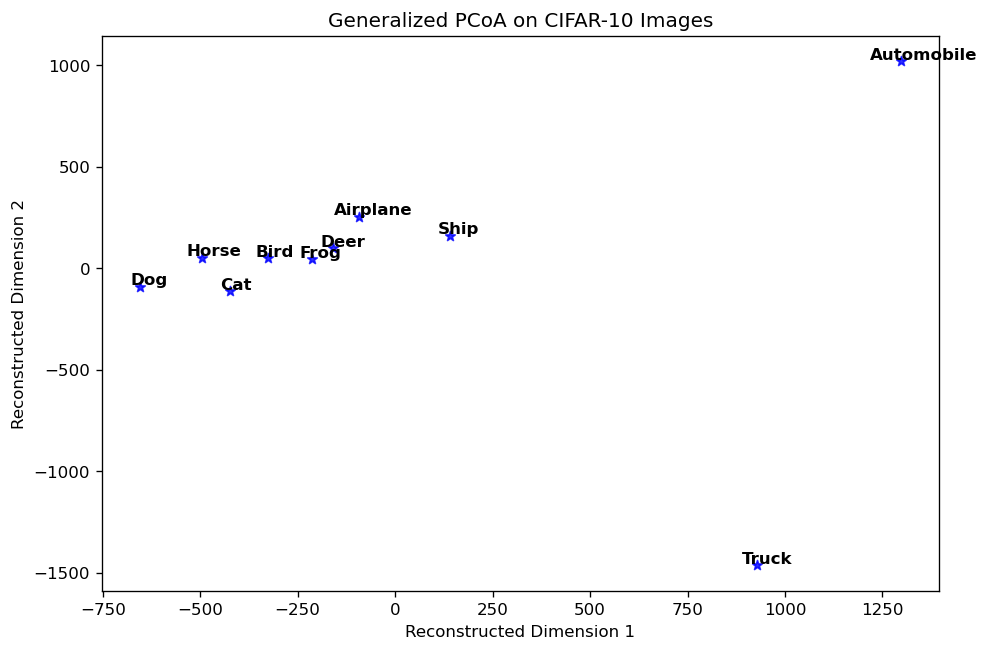

In [34]:
if perform_computation:
    class_names_list = sorted(list(class_to_idx.keys()))
    fig, ax = plt.subplots(figsize=(9,6.), dpi=120)
    x_components = VT[:,0]
    y_components = VT[:,1]
    sns.regplot(x=x_components, y=y_components, fit_reg=False, marker="*", color="Blue", ax=ax)
    for class_idx in range(VT.shape[0]):
        num_letters = len(class_names_list[class_idx])
        ax.text(x_components[class_idx]-num_letters*8, y_components[class_idx]+10, 
                class_names_list[class_idx].capitalize(), 
                horizontalalignment='left', size='medium', color='black', weight='semibold')
    ax.set_xlabel('Reconstructed Dimension 1')
    ax.set_ylabel('Reconstructed Dimension 2')
    _ = ax.set_title('Generalized PCoA on CIFAR-10 Images')